<a href="https://colab.research.google.com/github/hemanthkumar046/Innomatics_Internship_APR_21/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
#Creating Generator

In [72]:
def build_generator(image_size = 28, input_size = 100):
  gen_input = tf.keras.layers.Input(shape = (input_size,))

  x = tf.keras.layers.Dense(7 * 7 * 128)(gen_input)  #6272 neurons we are generating with intial random weight
  x = tf.keras.layers.Reshape((7, 7, 128))(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(128, kernel_size = [5,5], strides = 2, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(64, kernel_size = [5,5], strides = 2, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(32, kernel_size = [5,5], strides = 1, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(1, kernel_size = [5,5], strides = 1, padding='same')(x)

  x = tf.keras.layers.Activation('sigmoid')(x)

  generator = tf.keras.models.Model(gen_input, x, name = 'generator')

  return generator



In [73]:
build_generator().summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_27 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_15 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
activation_71 (Activation)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_56 (Conv2DT (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_58 (Batc (None, 14, 14, 128)       51

In [21]:
#Creating Discriminator

In [74]:
def build_discriminator(data_shape = [28, 28, 1, ]):
  dis_input = tf.keras.layers.Input(data_shape)

  x = tf.keras.layers.LeakyReLU(alpha = 0.2)(dis_input)
  x = tf.keras.layers.Conv2D(32, kernel_size = [5,5], strides = 2, padding = 'same')(x)

  x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
  x = tf.keras.layers.Conv2D(64, kernel_size = [5,5], strides = 2, padding = 'same')(x)

  x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size = [5,5], strides = 2, padding = 'same')(x)

  x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
  x = tf.keras.layers.Conv2D(256, kernel_size = [5,5], strides = 1, padding = 'same')(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

  discriminator = tf.keras.models.Model(dis_input, x, name = 'discriminator')

  return discriminator


In [75]:
build_discriminator().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 4, 4, 128)       

In [31]:
#Building full GAN for training

In [76]:
def build_model():
  noise_size = 100
  lr = 2e-4
  decay = 6e-8

  discriminator = build_discriminator(data_shape = (28,28,1))
  optimizer = tf.keras.optimizers.RMSprop(lr = lr, decay = decay)
  discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  generator = build_generator(image_size = 28, input_size = noise_size)

  frozen_discriminator = tf.keras.models.Model(inputs = discriminator.inputs, outputs = discriminator.outputs)
  frozen_discriminator.trainable = False

  #Adversarial = Generator + Discrimincator
  optimizer = tf.keras.optimizers.RMSprop(lr = lr*0.5, decay = decay*0.5)
  adversarial = tf.keras.models.Model(generator.inputs, frozen_discriminator(generator.outputs))

  adversarial.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  return generator, discriminator, adversarial


In [ ]:
g,d,a = build_model()

In [ ]:
#a.summary()

In [ ]:
#Train the model

In [77]:
def train_gan(generator, discriminator, adversarial, noise_size = 100):
  batch_size = 64
  epochs = 6000
  image_size = 28
  
  (train_x,_),(_,_) = tf.keras.datasets.mnist.load_data()

  train_x = np.reshape(train_x, [-1, image_size, image_size, 1])

  train_x = train_x.astype('float32')/255.

  test_noise_input = np.random.uniform(-1.0, 1.0, size = [16, noise_size]) ##16 noise signal, each and every singal length is 100

  for i in range(epochs):
    noise_input = np.random.uniform(-1.0, 1.0, size = [batch_size, noise_size])
    fake_images = generator.predict(noise_input)

    img_indexes = np.random.randint(0,train_x.shape[0], size = batch_size)
    real_images = train_x[img_indexes]

    X = np.concatenate((real_images, fake_images))

    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    y = np.concatenate((y_real, y_fake))

    d_loss, d_acc = discriminator.train_on_batch(X,y)

    X = noise_input = np.random.uniform(-1.0, 1.0, size = [batch_size, noise_size])

    y = np.ones((batch_size, 1))

    a_loss, a_acc = adversarial.train_on_batch(X,y)
        
    if i % 100 == 0:
            #Print loss and Accuracy for both networks
      print('epoch:',i,'discriminator_loss:',d_loss,'discriminator_acc:', d_acc,'adversarial_loss:',a_loss,'adversarial_acc:',a_acc)
            #print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
    if (i+1) % 500 == 0:
            
            #Generate 16 images
      fake_images = generator.predict(test_noise_input)
            
            #Display images
      plot_images(fake_images, i+1)
            
    #Save Generator model
    generator.save('mnist_generator_dcgan.h5')


In [78]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(2.5,2.5))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

In [79]:
G, D, A = build_model()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch: 0 discriminator_loss: 0.6960928440093994 discriminator_acc: 0.4140625 adversarial_loss: 1.0685843229293823 adversarial_acc: 0.0
epoch: 100 discriminator_loss: 1.4808305422775447e-05 discriminator_acc: 1.0 adversarial_loss: 0.00025432227994315326 adversarial_acc: 1.0
epoch: 200 discriminator_loss: 0.00023850382422097027 discriminator_acc: 1.0 adversarial_loss: 0.001441439613699913 adversarial_acc: 1.0
epoch: 300 discriminator_loss: 0.0012767615262418985 discriminator_acc: 1.0 adversarial_loss: 3.276939423813019e-06 adversarial_acc: 1.0
epoch: 400 discriminator_loss: 0.019378023222088814 discriminator_acc: 0.9921875 adversarial_loss: 0.0003759923274628818 adversarial_acc: 1.0


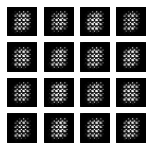

epoch: 500 discriminator_loss: 0.1948121339082718 discriminator_acc: 0.9765625 adversarial_loss: 2.6672794818878174 adversarial_acc: 0.0
epoch: 600 discriminator_loss: 0.010970673523843288 discriminator_acc: 1.0 adversarial_loss: 0.04148940369486809 adversarial_acc: 1.0
epoch: 700 discriminator_loss: 0.09593868255615234 discriminator_acc: 0.96875 adversarial_loss: 6.468352317810059 adversarial_acc: 0.0
epoch: 800 discriminator_loss: 1.302409052848816 discriminator_acc: 0.6953125 adversarial_loss: 2.396387815475464 adversarial_acc: 0.015625
epoch: 900 discriminator_loss: 0.2536006271839142 discriminator_acc: 0.9140625 adversarial_loss: 1.7567945718765259 adversarial_acc: 0.078125


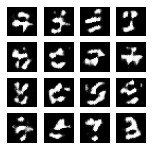

epoch: 1000 discriminator_loss: 0.48579925298690796 discriminator_acc: 0.7890625 adversarial_loss: 1.53242826461792 adversarial_acc: 0.015625
epoch: 1100 discriminator_loss: 0.5799992084503174 discriminator_acc: 0.7578125 adversarial_loss: 1.033875584602356 adversarial_acc: 0.21875
epoch: 1200 discriminator_loss: 0.583743155002594 discriminator_acc: 0.640625 adversarial_loss: 0.9276825189590454 adversarial_acc: 0.28125
epoch: 1300 discriminator_loss: 0.48122739791870117 discriminator_acc: 0.8125 adversarial_loss: 1.4483249187469482 adversarial_acc: 0.078125
epoch: 1400 discriminator_loss: 0.5438039898872375 discriminator_acc: 0.6953125 adversarial_loss: 0.8236740827560425 adversarial_acc: 0.421875


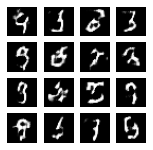

epoch: 1500 discriminator_loss: 0.6749672889709473 discriminator_acc: 0.640625 adversarial_loss: 2.175032615661621 adversarial_acc: 0.0
epoch: 1600 discriminator_loss: 0.5620781779289246 discriminator_acc: 0.6953125 adversarial_loss: 1.7938346862792969 adversarial_acc: 0.046875
epoch: 1700 discriminator_loss: 0.49539363384246826 discriminator_acc: 0.7890625 adversarial_loss: 0.9932733178138733 adversarial_acc: 0.296875
epoch: 1800 discriminator_loss: 0.4664069712162018 discriminator_acc: 0.8046875 adversarial_loss: 1.4037482738494873 adversarial_acc: 0.125
epoch: 1900 discriminator_loss: 0.5330650210380554 discriminator_acc: 0.7109375 adversarial_loss: 0.8587108254432678 adversarial_acc: 0.40625


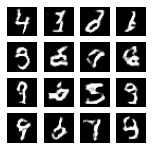

epoch: 2000 discriminator_loss: 0.48100125789642334 discriminator_acc: 0.7578125 adversarial_loss: 1.6495568752288818 adversarial_acc: 0.046875
epoch: 2100 discriminator_loss: 0.5011751055717468 discriminator_acc: 0.796875 adversarial_loss: 0.905903697013855 adversarial_acc: 0.46875


In [ ]:
train_gan(G, D, A)